# Plots for the figure that illustrats the problem

In [1]:
import torch # for some reason I need to import torch before numpy to avoid a kernel crash

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os, sys
rootpath = os.path.join(os.getcwd(), '.')
sys.path.append(rootpath)
from src.simulation import *
from src.approximation import *
from src.theory import *
from src.analysis import *
# reimport modules if they change
%load_ext autoreload
%autoreload 2

In [2]:
params = {
    'N': int(1e4),
    'K': 100,
    'mu': 0.2,
    'sigma': 0.01,
    "epsilon": 0.1,
    'seed': 1000,
    'seed_d': 1000,
    'nu' : 0.2,
}
plt.text.usetex : True
# font size
plt.rcParams.update({'font.size': 8})
# # tick size
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
kwargs_figures = {
    'transparent': True,
    'dpi': 300,
    'bbox_inches': 'tight',
}

SyntaxError: ':' expected after dictionary key (1577727771.py, line 9)

## Example trajectories

In [3]:
# set table (lambda, Tlist, h) with simulation parameters
lams = [0.9, 0.99, 0.999]
windows = [1e1, 1e2, 1e3]
# create examples dataframe with np.meshgrid
lams, windows = np.meshgrid(lams, windows)
examples = pd.DataFrame({
    'lambda': lams.flatten(),
    'window': windows.flatten()
})
print(examples)

   lambda  window
0   0.900    10.0
1   0.990    10.0
2   0.999    10.0
3   0.900   100.0
4   0.990   100.0
5   0.999   100.0
6   0.900  1000.0
7   0.990  1000.0
8   0.999  1000.0


In [4]:
# generate example simulations if not already saved in /dat/example_simulations
traces = []
T_record = int(1e4)
delta = 5*params['sigma'] # to minimize overlap for large T 
a1=0.5 - delta/2
a2=0.5 + delta/2
_filename = lambda lam, window : f'dat/example_simulations/trace_lambda={lam}_window={window}.txt'
# unique lambda
for i, row in examples.iterrows():
    filename_load = _filename(row['lambda'], row['window'])
    # check if file exists and if not simulate for all windows
    if not os.path.exists(filename_load):
        print(f"Simulating for lambda={row['lambda']} all windows")
        windows = examples[examples['lambda'] == row['lambda']]['window'].values
        params['lambda'] = row['lambda']
        # get 2 input rates at close but different mean activities
        h1 = scipy.optimize.bisect(lambda h: mean_field_activity(params['lambda'], params['mu'], h) - a1, 0, 1)
        params['h'] = h1
        params['seed_d'] = 1234
        result_h1 = simulation(params, windows=windows, steps={'burn':int(1e3), 'equil':2*int(np.max(windows)), 'record':T_record})
        h2 = scipy.optimize.bisect(lambda h: mean_field_activity(params['lambda'], params['mu'], h) - a2, 0, 1)
        params['h'] = h2
        params['seed_d'] = 4321 
        result_h2 = simulation(params, windows=windows, steps={'burn':int(1e3), 'equil':2*int(np.max(windows)), 'record':T_record})
        # write to file(s)
        for window in windows:
            filename_create = _filename(row['lambda'], window)
            # combine trace from result_h1 and result_h2 in 2D array
            trace = np.vstack(([result_h1['samples'][window], result_h2['samples'][window]])).T
            np.savetxt(filename_create, trace)
    
    # load next file 
    print(f"Loading {i+1}/{len(examples)}: {filename_load}")
    traces.append(np.loadtxt(filename_load))


Loading 1/9: dat/example_simulations/trace_lambda=0.9_window=10.0.txt
Loading 2/9: dat/example_simulations/trace_lambda=0.99_window=10.0.txt
Loading 3/9: dat/example_simulations/trace_lambda=0.999_window=10.0.txt
Loading 4/9: dat/example_simulations/trace_lambda=0.9_window=100.0.txt
Loading 5/9: dat/example_simulations/trace_lambda=0.99_window=100.0.txt
Loading 6/9: dat/example_simulations/trace_lambda=0.999_window=100.0.txt
Loading 7/9: dat/example_simulations/trace_lambda=0.9_window=1000.0.txt
Loading 8/9: dat/example_simulations/trace_lambda=0.99_window=1000.0.txt
Loading 9/9: dat/example_simulations/trace_lambda=0.999_window=1000.0.txt


In [5]:
# colors in fig_results
colors_fig_results = [(0.9978256142639704, 0.9565122852794086, 0.6651445966514459, 1.0), (0.9865579108355671, 0.8655440258295098, 0.36898156522883124, 1.0), (0.9375300805253609, 0.5770341013117577, 0.22944081742285957, 1.0), (0.8428398756762985, 0.3113809907524655, 0.11267411074018642, 1.0), (0.3503415064655997, 0.21353363263113462, 0.17790568282107366, 1.0)]
print(len(colors_fig_results))

5


[-0.5   -0.499 -0.498 ...  9.497  9.498  9.499]


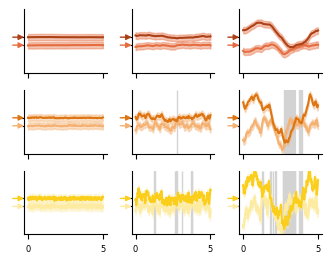

In [6]:
import colorsys

# make matrix of plots
lams = np.sort(examples['lambda'].unique())
windows = np.sort(examples['window'].unique())
windows_results = [1e0,1e1,1e2,1e3,1e4]

# plot example traces
time = np.arange(T_record)/1000.0
# select [0,5]s window, shift time if necessary
time -= 0.5
mask = (0 < time) & (time < 5)
print(time)

cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(len(lams), len(windows), figsize=(8.5*cm, 6.8*cm), sharex=True, sharey=True)
a_min=0.30
a_max=0.70
oy = len(windows)-1
for (i,lam) in enumerate(lams):
    for (j,window) in enumerate(windows):
        np.random.seed(1234) # ensure noise is the same for all examples
        id_results = windows_results.index(window)
        
        # get index of example for this lambda, window combination
        idx = examples[(examples['lambda']==lam) & (examples['window']==window)].index[0]
        # create noisy output by multiplying with uncorrelated Gaussian noise
        trace = traces[idx] #+ np.random.randn(*traces[idx].shape)*params['sigma']
        
        # draw gray background from bottom to top whenever trace[:,0] > trace[:,1]
        ax[oy-j, i].fill_between(time[mask], a_min, a_max, where=trace[:,0][mask]>trace[:,1][mask], color='lightgray', rasterized=True)
        # convert color to h,l,s to adjust brightness
        color = colors_fig_results[id_results]
        h,l,s = colorsys.rgb_to_hls(*color[0:3])
        # first trace with lighter line
        color1 = colorsys.hls_to_rgb(h,l*1.2,s)
        # make opaque band around trace for the noise with width sigma
        ax[oy-j, i].fill_between(time[mask], trace[:,0][mask]-2*params['sigma'], trace[:,0][mask]+2*params['sigma'], color=color1, alpha=0.4, rasterized=True)
        ax[oy-j, i].plot(time[mask], trace[:,0][mask], color=color1)

        # second trace with darker line
        color2 = colorsys.hls_to_rgb(h,l*0.8,s)
        ax[oy-j, i].fill_between(time[mask], trace[:,1][mask]-2*params['sigma'], trace[:,1][mask]+2*params['sigma'], color=color1, alpha=0.4, rasterized=True)
        ax[oy-j, i].plot(time[mask], trace[:,1][mask], color=color2)
        

        ax[oy-j, i].set_ylim([a_min, a_max])

        # remove right and top spines
        ax[oy-j, i].spines['right'].set_visible(False)
        ax[oy-j, i].spines['top'].set_visible(False)

        # add ticks manually
        ax[oy-j, i].set_xticks([0, 5])
        # no ticks for y-axis but instead draw small arrows at respective places in the colors of the traces
        ax[oy-j, i].set_yticks([a1,a2])
        # arrow with annotate
        ax[oy-j, i].annotate('', xy=(-0.07, a1), xytext=(-1.2, a1), arrowprops=dict(facecolor='white', edgecolor='white', arrowstyle='-|>', linewidth=1))
        ax[oy-j, i].annotate('', xy=(-0.07, a1), xytext=(-1.2, a1), arrowprops=dict(facecolor=color1, edgecolor=color1, arrowstyle='-|>', linewidth=1))
        ax[oy-j, i].annotate('', xy=(-0.07, a2), xytext=(-1.2, a2), arrowprops=dict(facecolor=color2, edgecolor=color2, arrowstyle='-|>', linewidth=1))


        # remove labels of tics
        ax[oy-j, i].set_yticklabels([])
        ax[oy-j, i].set_xticklabels([])

ax[oy-1, 0].set_xticklabels([0, 5])
fig.tight_layout()
fig.savefig("./figures/fig_problem_examples.pdf", **kwargs_figures)

Calculate the overlap for all 9 cases

Overlap between traces from example:


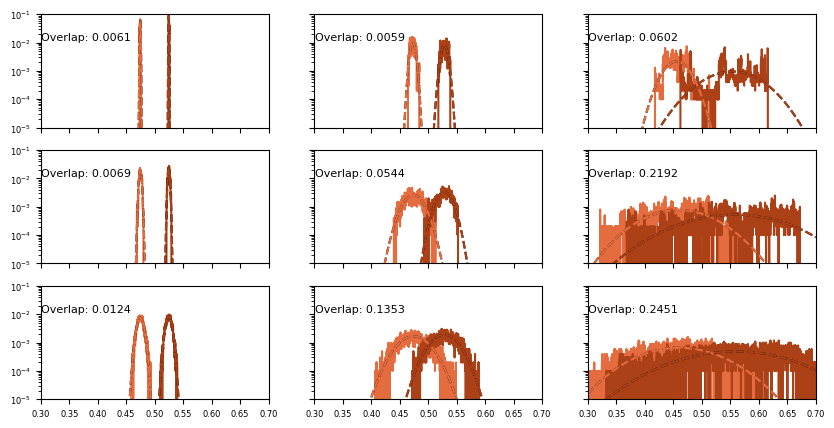

In [7]:
fig, ax = plt.subplots(len(lams), len(windows), figsize=(10,5), sharex=True, sharey=True)
delta = 1/params['N']
# support for the gaussian noise
x_gauss = support_gauss(5 * params["sigma"], delta)
# pmf of the gaussian noise (needs delta for normalization)
pmf_gauss = stats.norm.pdf(x_gauss, 0, params["sigma"]) * delta 
x_beta = support_conv_pmf_gauss([0,1+delta], x_gauss)
x_noise = support_conv_pmf_gauss([0,1], x_gauss)
oy = len(windows)-1
x_min=0.30
x_max=0.70

print("Overlap between traces from example:")
for (i,lam) in enumerate(lams):
    for (j,window) in enumerate(windows):
        np.random.seed(1234) # ensure noise is the same for all examples
        id_results = windows_results.index(window)
        
        # get index of example for this lambda, window combination
        idx = examples[(examples['lambda']==lam) & (examples['window']==window)].index[0]
        # create noisy output by multiplying with uncorrelated Gaussian noise
        trace = traces[idx]

        # first trace 
        data = trace[:,0]
        pmf_data = np.histogram(data, bins=x_beta, density=False)[0]/len(data)
        ax[oy-j, i].plot(x_noise, pmf_data, color=color1)
        #fit
        a,b,loc,scale = fit_beta_distribution(data, delta)
        pmf_beta_1 = np.diff(stats.beta.cdf(x_beta, a, b, loc=loc, scale=scale))
        ax[oy-j, i].plot(x_noise, pmf_beta_1, color='black', linestyle='--')

        # second trace 
        data = trace[:,1]
        pmf_data = np.histogram(data, bins=x_beta, density=False)[0]/len(data)
        ax[oy-j, i].plot(x_noise, pmf_data, color=color2)
        #fit
        a,b,loc,scale = fit_beta_distribution(data, delta)
        pmf_beta_2 = np.diff(stats.beta.cdf(x_beta, a, b, loc=loc, scale=scale))
        ax[oy-j, i].plot(x_noise, pmf_beta_2, color='black', linestyle='--')

        # calculate overlap after convolution with gaussian
        pmf_noise_1 = np.convolve(pmf_beta_1, pmf_gauss, mode="same")
        pmf_noise_2 = np.convolve(pmf_beta_2, pmf_gauss, mode="same")
        ax[oy-j, i].plot(x_noise, pmf_beta_1, color=color1, linestyle='--')
        ax[oy-j, i].plot(x_noise, pmf_beta_2, color=color2, linestyle='--')

        overlap = calc_overlap(pmf_noise_1, pmf_noise_2)
        # print overlap in plot
        ax[oy-j, i].text(0.2, 0.8, f"Overlap: {overlap:.4f}", horizontalalignment='center', verticalalignment='center', transform=ax[oy-j, i].transAxes)

        ax[oy-j, i].set_xlim([a_min, a_max])
        ax[oy-j, i].set_yscale('log')
        ax[oy-j, i].set_ylim(bottom=1e-5, top=1e-1)


/var/folders/1n/3p6th0xd5058w0ldlcm64jcm0000gn/T/ipykernel_20155/2523140213.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


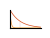

In [8]:
# plot exponential kernels for windows in single plot
fig, ax = plt.subplots(1, 1, figsize=(1*cm, 0.6*cm))
xs = np.linspace(0, windows[-1]*3, 2000)
for window in windows:
    id_results = windows_results.index(window)
    ax.plot(xs, np.exp(-xs/window), color=colors_fig_results[id_results], linewidth=0.5)
    # veritical line at window from zero to function value
    ax.plot([window, window], [0, np.exp(-1)], color=colors_fig_results[id_results], linewidth=0.1)

# set xlims
ax.set_xlim([0, windows[-1]*3])
# set ylims
ax.set_ylim([0, 1])
# no ticks
ax.set_xticks([])
ax.set_yticks([])
# remove right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()

# save figures
fig.savefig("./figures/fig_problem_examples_kernel.pdf", **kwargs_figures)

## Illustration of the overlap using beta interpolation
Specific example

In [9]:
# set seed to a value for which database entry exists
params["seed"] = 1000

lam = 0.999
window = 10

xmin=5e-5
xmax=5e-1
ymin=-0.03
ymax=1.09

In [10]:
# load relevant information from database
import sqlite3
database = "./simulations.db"
con = sqlite3.connect(database)
cur = con.cursor()

# load function approximation from database
beta_interpolation = pd.read_sql_query(
    f"SELECT * FROM beta_interpolations WHERE N={params['N']} AND K={params['K']} AND mu={params['mu']} AND seed={params['seed']}",
    con,
)
# check that there is a unique function approximation
if not len(beta_interpolation) == 1:
    raise ValueError(
        f"No unique function approximation in database for params (either 0 or multiple entries)"
    )
print(
    f"Load beta interpolation from file: {beta_interpolation['filename'].values[0]}"
)
beta_approx = FunctionApproximation(
    filename=beta_interpolation["filename"].values[0]
)
con.close()

Load beta interpolation from file: ./dat/beta_interpolation_N=10000_K=100_mu=0.2_seed=1000.pkl


In [11]:
# parameters of the beta distribution
loc = beta_approx.params["loc"]
scale = beta_approx.params["scale"]
# support for the gaussian noise
delta = 1 / beta_approx.params["N"]
x_gauss = support_gauss(5 * params["sigma"], delta)
# pmf of the gaussian noise (needs delta for normalization)
pmf_gauss = stats.norm.pdf(x_gauss, 0, params["sigma"]) * delta 

# full support for convolution (add another delta to the right because beta distribution is calculated from the difference of the cdf)
x_beta = support_conv_pmf_gauss([0,1+delta], x_gauss)
x_noise = support_conv_pmf_gauss([0,1], x_gauss)

def pmf_noise(window, lam, h):
    a,b = beta_approx(lam, window, h)
    # pmf as difference of cdf to ensure that the pmf is normalized
    pmf = np.diff(stats.beta.cdf(x_beta, a, b, loc=loc, scale=scale))
    return np.convolve(pmf, pmf_gauss, mode="same")

pmf_o_given_h = lambda h: pmf_noise(window, lam, h)

In [12]:
# find disriminable points
# get reference distributions from mean-field solution (needs delta for normalization because in domain [0,1] with stepsize delta)
pmf_refs = [stats.norm.pdf(x_noise, mean_field_activity(lam, params['mu'], h), params['sigma'])*delta for h in [0, np.inf]]

# get dynamic range and number of discriminable states
h_range = beta_approx.input_range[beta_approx.input_names.index("h")]
hs_left = find_discriminable_inputs(pmf_o_given_h, h_range, pmf_refs, params["epsilon"], start="left")
hs_right = find_discriminable_inputs(pmf_o_given_h, h_range, pmf_refs, params["epsilon"], start="right")

In [13]:
# calculate the median and 25/75 percentiles of the noisy activity for different input rates
hs = 10**np.linspace(-5, -0, 100)   
percentile_05 = np.zeros_like(hs)
percentile_50 = np.zeros_like(hs)
percentile_95 = np.zeros_like(hs) 
for (i,h) in tqdm(enumerate(hs)):
    pmf_h = pmf_o_given_h(h)
    cdf = np.cumsum(pmf_h)
    # percentiles as the first index where the cdf is larger than the respective value
    percentile_05[i] = x_noise[np.argmax(cdf > 0.05)]
    percentile_50[i] = x_noise[np.argmax(cdf > 0.50)]
    percentile_95[i] = x_noise[np.argmax(cdf > 0.95)]


100it [00:00, 153.28it/s]


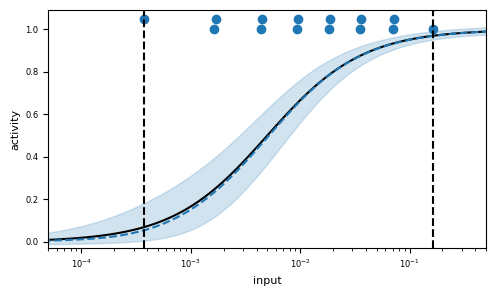

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(5, 3))

# theory
axes.plot(hs, mean_field_activity(lam, params['mu'], hs), color='black', label='theory')
ref = axes.plot(hs, percentile_50,linestyle='--')
axes.fill_between(hs, percentile_05, percentile_95, color=ref[0].get_color(), alpha=0.2)
# plot hs_left points on top as anotate points
axes.scatter(hs_left, np.ones_like(hs_left)*1.05, color=ref[0].get_color())
axes.scatter(hs_right, np.ones_like(hs_left), color=ref[0].get_color())
# plot dynamic range as vertical lines from hs_left[0] to hs_right[0]
axes.axvline(hs_left[0], color='black', linestyle='--')
axes.axvline(hs_right[0], color='black', linestyle='--')
#axes.set_yscale("log")
axes.set_xscale("log")
axes.set_xlabel("input")
axes.set_ylabel("activity")
# set lims
axes.set_xlim([xmin, xmax])
axes.set_ylim([ymin, ymax])
#axes.legend()
plt.tight_layout()
plt.show()

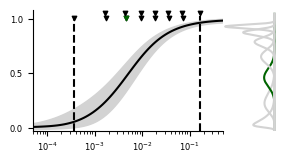

In [15]:
cm = 1/2.54  # centimeters in inches
fig, axes = plt.subplots(1,2, width_ratios=[3.5,1], figsize=(8*cm, 4*cm))

####### Left part of figure with response
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
# unset tickslabels
# set ticks
axes[0].set_yticks([0,0.5,1])
# set lims
axes[0].set_xlim([xmin, xmax])
axes[0].set_ylim([ymin, ymax])
axes[0].set_xscale("log")
#unset tickslabel
#axes[0].set_xticklabels([])
#axes[0].set_yticklabels([])

axes[0].plot(hs, percentile_50, color='black')
axes[0].fill_between(hs, percentile_05, percentile_95, color='lightgray')

# select one hs_left for illustration
color_sel = "darkgreen"
id_sel = 2

# plot dynamic range bounds from 0.05 to 0.95
axes[0].axvline(hs_left[0], ymax=0.95, color='black', linestyle='--')
axes[0].axvline(hs_right[0], ymax=0.95, color='black', linestyle='--')
# plot hs_left and hs_reft as scatter with markers as triangles
axes[0].scatter(hs_left, np.ones_like(hs_left)*1.01, color='black', marker='v', s=10)
axes[0].scatter(hs_left[id_sel], 1.01, color=color_sel, marker='v', s=10)
axes[0].scatter(hs_right, np.ones_like(hs_left)*1.06, color='black', marker='v', s=10)

####### right part of figure with distribtions
axes[1].spines['left'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
# remove y-axis
axes[1].set_yticklabels([])
axes[1].set_yticks([])
axes[1].yaxis.tick_right()
# unset xtics
axes[1].set_xticks([])
axes[1].set_ylim([ymin, ymax])

# plot pmf for hs in hs_left on y2-axis
for (i,h) in enumerate(hs_left):
    color = color_sel if i == id_sel else 'lightgray'
    pmf_h = pmf_o_given_h(h)
    # plot on y2 axis
    axes[1].plot(1-pmf_h, x_noise, color=color)

fig.subplots_adjust(wspace=0, hspace=0)

fig.savefig("./figures/fig_problem_response.pdf", **kwargs_figures)